In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
import tensorflow as tf
import matplotlib.ticker as ticker
warnings.filterwarnings('ignore')


# Set the path to the root directory
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(path)

# Import the data
df_read = pd.read_csv(path + '/data/predictions/heston.csv')
df = df_read.copy()

# Rename BS column to prediction
df = df.rename(columns={'Heston_price': 'Prediction'})

# For heston, the TTM is in years, so we convert it to days
df["TTM"] = df["TTM"] * 365
df["R"] = df["R"] * 100

2023-05-01 18:06:43.632915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Params

In [3]:
base = 500

In [4]:
display(df)

,Unnamed: 0,Unnamed: 0.1,Quote_date,Price,Underlying_last,Strike,TTM,R,Moneyness,Prediction,Expire_date
0,10444899,10444899,2022-01-03,2394.150,4795.57,2400.0,2.0,0.05,1.998154,2388.579496,NaN
1,10444900,10444900,2022-01-03,2294.150,4795.57,2500.0,2.0,0.05,1.918228,2300.043418,NaN
2,10444901,10444901,2022-01-03,2194.150,4795.57,2600.0,2.0,0.05,1.844450,2195.851375,NaN
3,10444902,10444902,2022-01-03,2094.150,4795.57,2700.0,2.0,0.05,1.776137,2090.829585,NaN
4,10444903,10444903,2022-01-03,1994.150,4795.57,2800.0,2.0,0.05,1.712704,2002.278288,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9448527,3923124,3923124,2017-12-29,107.450,2675.22,2950.0,721.0,1.89,0.906854,117.010157,NaN
9448528,3923125,3923125,2017-12-29,88.800,2675.22,3000.0,721.0,1.89,0.891740,101.025617,NaN
9448529,3923126,3923126,2017-12-29,58.650,2675.22,3100.0,721.0,1.89,0.862974,73.163965,NaN
9448530,3923127,3923127,2017-12-29,37.050,2675.22,3200.0,721.0,1.89,0.836006,50.116375,NaN


In [48]:
print("RMSE for full period", np.sqrt(np.mean((df['Prediction'] - df['Price'])**2)))

# Print total number of days
print("Total number of days: ", len(df['Quote_date'].unique()))

RMSE for full period 15.822116593776682
Total number of days:  2001


## Quote Date

2023-05-01 18:07:14.152122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


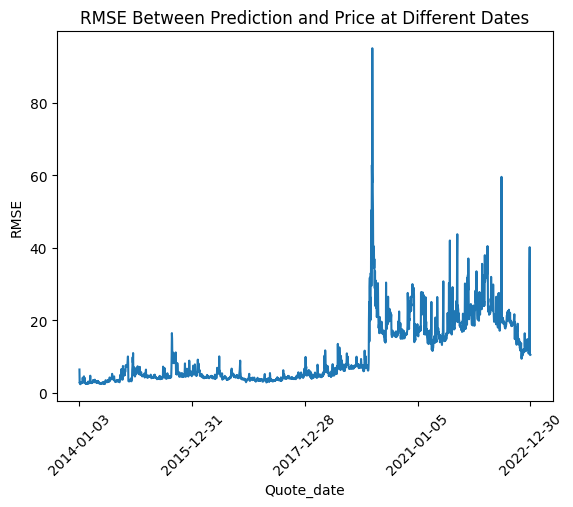

In [5]:
# Graph the RMSE between prediction and price for different dates like above
def calculate_rmse(group):
    mse = tf.keras.losses.MSE(group['Price'], group['Prediction'])
    rmse = np.sqrt(mse)
    return rmse

rmse_by_date = df.groupby('Quote_date').apply(calculate_rmse).reset_index(name='RMSE')

# create axis
fig, ax = plt.subplots()

# Set the interval for x-axis labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=base))

sns.lineplot(x='Quote_date', y='RMSE', data=rmse_by_date)
plt.title("RMSE Between Prediction and Price at Different Dates")
plt.xlabel("Quote_date")
plt.xticks(rotation=45)
plt.ylabel("RMSE")
plt.show()

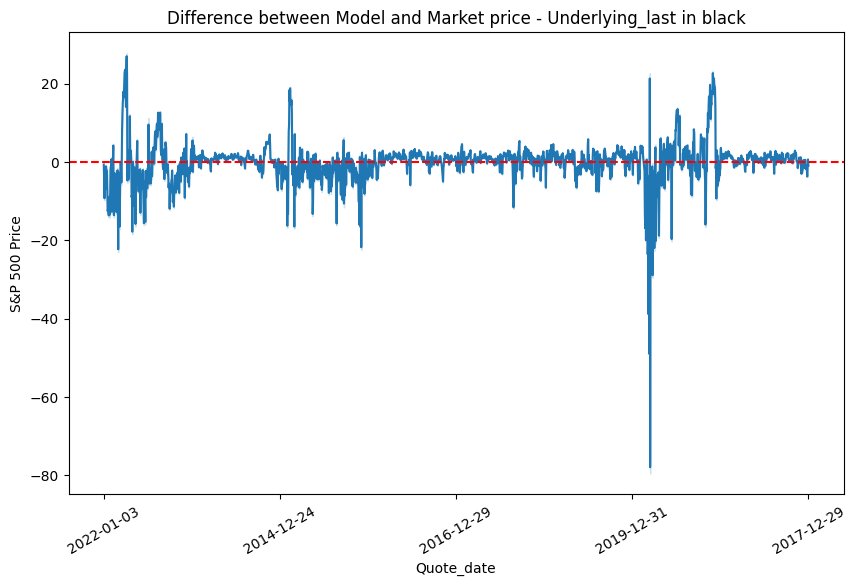

In [58]:
# New column with the difference between the prediction and the actual value
df["Diff"] = df["Prediction"] - df["Price"]

# Plot the difference
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df, x="Quote_date", y="Diff", ax=ax)

# Set the interval for x-axis labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=base))
plt.ylabel("Prediction - Market Price")

# Add zero line
plt.axhline(y=0, color="red", linestyle="--", label = "Actual Price")

# Adding underlying
df_underlying = df.groupby("Quote_date")["Underlying_last"].mean().reset_index()


# Create a second y-axis for Underlying_last values
#ax2 = ax.twinx()
#sns.lineplot(data=df_underlying, x="Quote_date", y="Underlying_last", label="Underlying_last", color="black", ax=ax2, linestyle="--")


plt.xlabel("Quote_date")
plt.ylabel("S&P 500 Price")
plt.title("Difference between Model and Market price - Underlying_last in black")
plt.xticks(rotation=30)
plt.show()

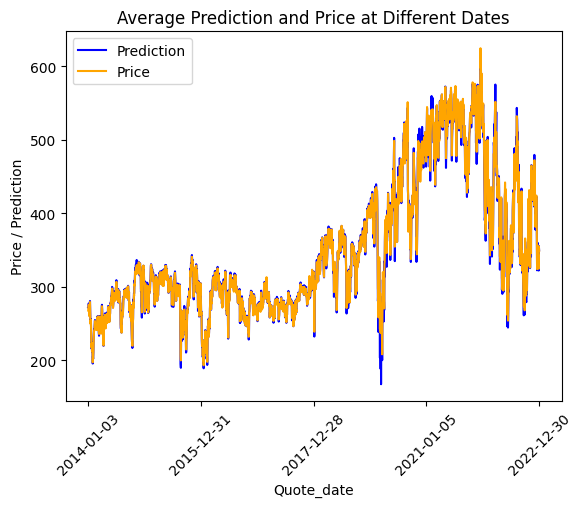

In [51]:
# Plot the average prediction and price for different dates
def calculate_average(group):
    average_prediction = group['Prediction'].mean()
    average_price = group['Price'].mean()
    return pd.Series({'Average Prediction': average_prediction, 'Average Price': average_price})

average_by_date = df.groupby('Quote_date').apply(calculate_average).reset_index()


# create axis
fig, ax = plt.subplots()

# Set the interval for x-axis labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=base))

sns.lineplot(x='Quote_date', y='Average Prediction', data=average_by_date, color='blue', label='Prediction')
sns.lineplot(x='Quote_date', y='Average Price', data=average_by_date, color='orange', label='Price')
plt.title("Average Prediction and Price at Different Dates")
plt.xlabel("Quote_date")
plt.xticks(rotation=45)
plt.ylabel("Price / Prediction")
plt.legend()
plt.show()



## TTM

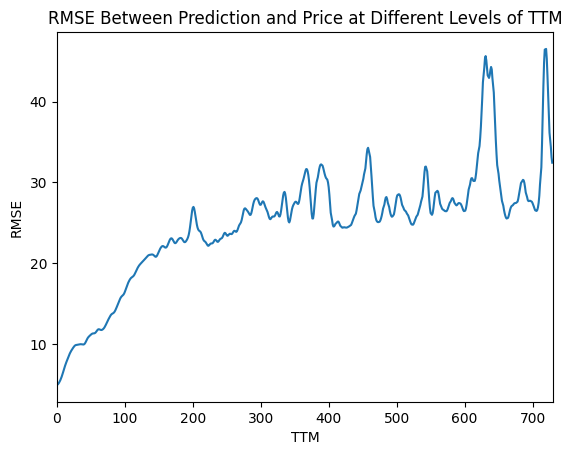

In [19]:
# Graph the RSME between prediction and price for different levels of TTM
rmse_by_ttm = df.groupby('TTM').apply(calculate_rmse).reset_index(name='RMSE')

# Smooth the using gaussian filter and sigma = 2
rmse_by_ttm['RMSE'] = gaussian_filter1d(rmse_by_ttm['RMSE'], sigma=3)


sns.lineplot(x='TTM', y='RMSE', data=rmse_by_ttm)
plt.title("RMSE Between Prediction and Price at Different Levels of TTM")
plt.xlabel("TTM")
plt.ylabel("RMSE")

plt.xlim(0, 730)
plt.show()

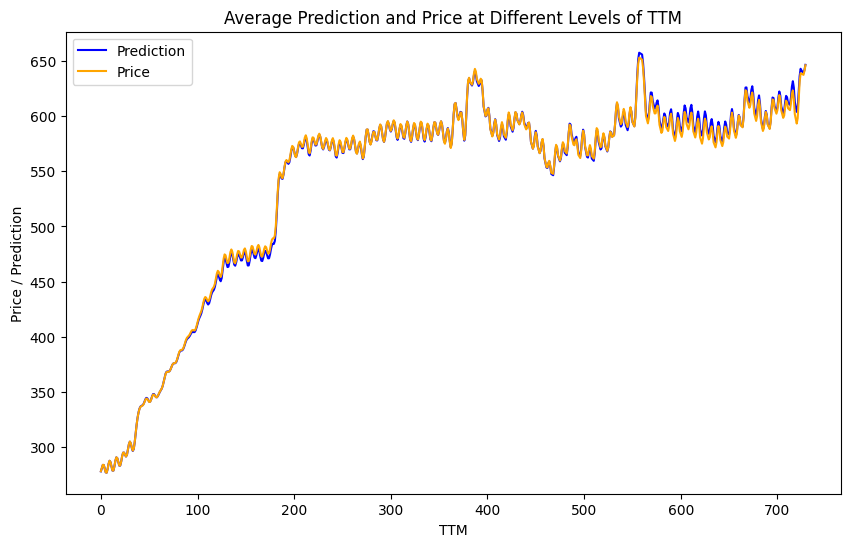

In [16]:
def calculate_average(group):
    average_prediction = group['Prediction'].mean()
    average_price = group['Price'].mean()
    return pd.Series({'Average Prediction': average_prediction, 'Average Price': average_price})

average_by_ttm = df.groupby('TTM').apply(calculate_average).reset_index()

# Smooth the using gaussian filter and sigma = 2
average_by_ttm['Average Prediction'] = gaussian_filter1d(average_by_ttm['Average Prediction'], sigma=2)
average_by_ttm['Average Price'] = gaussian_filter1d(average_by_ttm['Average Price'], sigma=2)


plt.figure(figsize=(10, 6))
sns.lineplot(x='TTM', y='Average Prediction', data=average_by_ttm, color='blue', label='Prediction')
sns.lineplot(x='TTM', y='Average Price', data=average_by_ttm, color='orange', label='Price')
plt.title("Average Prediction and Price at Different Levels of TTM")
plt.xlabel("TTM")
plt.ylabel("Price / Prediction")
plt.legend()
plt.show()


## Underlying

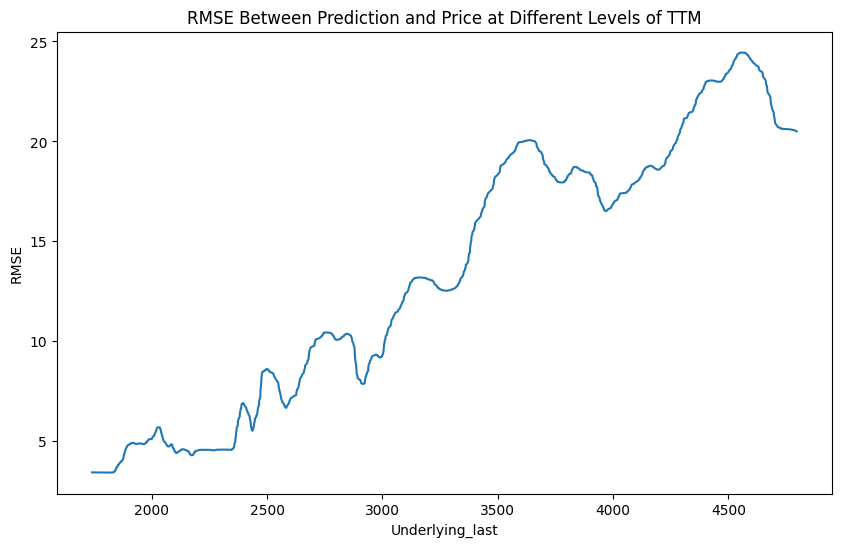

In [18]:
# Graph the RSME between prediction and price for different levels of TTM
def calculate_rmse(group):
    rmse = np.sqrt(tf.keras.losses.MSE(group['Price'], group['Prediction']))
    return rmse

rmse_by_underling= df.groupby('Underlying_last').apply(calculate_rmse).reset_index(name='RMSE')

# Smooth graph using gaussian filter and sigma = 2
rmse_by_underling['RMSE'] = gaussian_filter1d(rmse_by_underling['RMSE'], sigma=20)

plt.figure(figsize=(10, 6))
sns.lineplot(x='Underlying_last', y='RMSE', data=rmse_by_underling)
plt.title("RMSE Between Prediction and Price at Different Levels of TTM")
plt.xlabel("Underlying_last")
plt.ylabel("RMSE")
plt.show()

## Moneyness

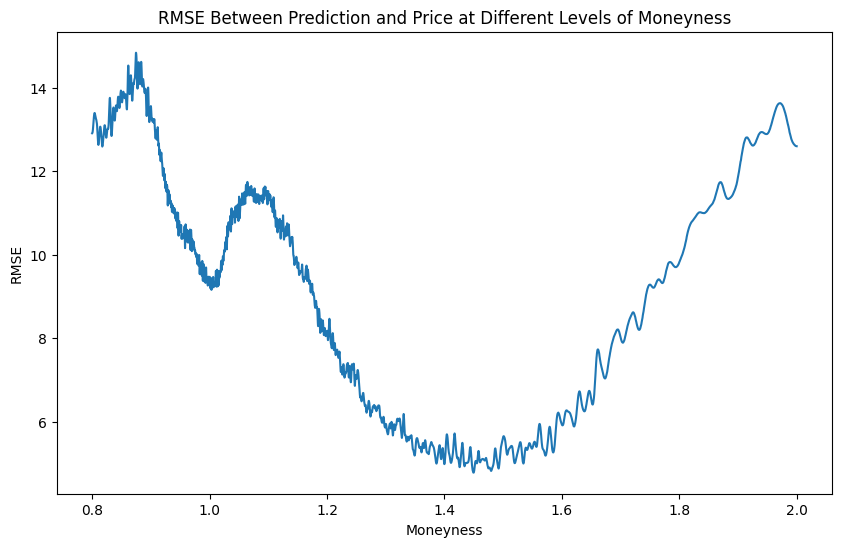

In [8]:
# Add moneyness column
df['Moneyness'] = df['Underlying_last'] / df['Strike']

# Graph the RSME between prediction and price for different levels of moneyness
def calculate_rmse(group):
    rmse = np.sqrt(tf.keras.losses.MSE(group['Price'], group['Prediction']))
    return rmse

rmse_by_moneyness = df.groupby('Moneyness').apply(calculate_rmse).reset_index(name='RMSE')

# Smooth the graph using gaussian filter
from scipy.ndimage import gaussian_filter1d
rmse_by_moneyness['RMSE'] = gaussian_filter1d(rmse_by_moneyness['RMSE'], sigma=500)


plt.figure(figsize=(10, 6))
sns.lineplot(x='Moneyness', y='RMSE', data=rmse_by_moneyness)
plt.title("RMSE Between Prediction and Price at Different Levels of Moneyness")
plt.xlabel("Moneyness")
plt.ylabel("RMSE")
plt.show()